In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


I'm gointo ignore everything, but the text for now.  I think I will run a naive-bayes

<BarContainer object of 2 artists>

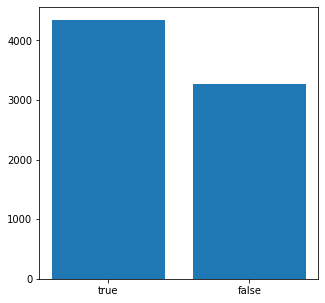

In [5]:
targets = list(train_data['target'])
true_tweets = targets.count(0)
false_tweets = targets.count(1)

plt.figure(figsize=(5,5))
plt.bar(['true','false'],[true_tweets, false_tweets])

In [6]:
print(str(true_tweets / len(targets)) + ' percent of tweets are True')
print(str(false_tweets / len(targets)) + ' percent of tweets are False')

0.5703402075397347 percent of tweets are True
0.4296597924602653 percent of tweets are False


# Use NLTK to process the tweets, and create a simpler text without punctuation.

In [7]:
# importing NLTK libarary stopwords 
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Set up stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stemmer
def word_stemmer(words):
    stem_words = [stemmer.stem(o) for o in words]
    return " ".join(stem_words)

# Lemmatizer
def word_lemmatizer(words):
    lemma_words = [lemmatizer.lemmatize(o) for o in words]
    return " ".join(lemma_words)


# Create a function that will strip out punctuation, lower_case, and strip out stop words.
def modify_text_list(text_lst):
    modified_text_lst = list()
    for entry in text_lst:
        text = entry
        text = text.lower()
        letters = list(text)
        alphabet = ' abcdefghijklmnopqrstuvwxyz'
        new_text = ''
        i = 0
        while i < len(letters):
            letter = letters[i]
            if letter in alphabet:
                new_text += letter
            i += 1
        text_tokens = word_tokenize(new_text)
        tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
        tokens_without_sw = ' '.join(tokens_without_sw)
        tokens_without_sw = word_stemmer(tokens_without_sw.split(' '))
        tokens_without_sw = word_lemmatizer(tokens_without_sw.split(' '))
        modified_text_lst.append(tokens_without_sw)
    return modified_text_lst

# Update train_data
tweets = train_data["text"]
tweets = list(tweets)
modified_tweets = modify_text_list(tweets)
train_data['modified_tweets'] = modified_tweets

# Update test_data
tweets = test_data["text"]
tweets = list(tweets)
modified_tweets = modify_text_list(tweets)
test_data['modified_tweets'] = modified_tweets

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Set up a pipeline

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [9]:
X = train_data['modified_tweets']
y = train_data['target']

model.fit(X, y)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [10]:
predictions = model.predict(test_data['modified_tweets'])

In [11]:
output = pd.DataFrame({'id': test_data.id, 'target': predictions})
output.to_csv('submission.csv', index=False)